# ResNet50 Model 

#### With only 2 emotions on ResNet50 and ResNet50V2

In [34]:
# Core Dependencies (for all models)
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Dependencies
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

# Custom Dependencies (for ResNet50)
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

In [35]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices: 
    print("GPU is available") 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU is not available") 

GPU is not available


### Load and Pre-process FER2013 Dataset

In [36]:
# Define the Paths 
dataset_train = 'FER2013/train'
dataset_test = 'FER2013/test'

# Define the Image Size and Parameters
img_size = (48, 48)
input_shape = (48, 48, 3)
batch_size = 64

## Trial #3: ResNet50 with Pretrained Weights

### Create Data Generators 

In [37]:
# Data Preprocessing and augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator 
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10239 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


### Load ResNet50 Base with ImageNet Weights

In [38]:
# Add class weights 
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [39]:
# Define ResNet50V2 model (pretrained w/ Imagenet Weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model (for now)
for layer in base_model.layers:
    layer.trainable = False

### Define the ResNet Model

In [40]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model_3 = Model(inputs=base_model.input, outputs=output)

In [41]:
# Create a loss function that is appropriate for multi-class classification
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile the ResNet Model 
model_3.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=['accuracy'])

initial_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

### Train the Model

#### Phase 1: Inital Training

In [42]:
# Start the initial training
history = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=initial_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5098 - loss: 0.7909 - val_accuracy: 0.4031 - val_loss: 0.6976 - learning_rate: 0.0010
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.5112 - loss: 0.6962 - val_accuracy: 0.4009 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.4256 - loss: 0.6928 - val_accuracy: 0.4009 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.4832 - loss: 0.6913 - val_accuracy: 0.4009 - val_loss: 0.6953 - learning_rate: 0.0010
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.4387 - loss: 0.6941 - val_accuracy: 0.4009 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.4109 - loss: 0.6942 - val_accuracy: 0.6002 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.5963 - loss:

#### Phase 2: Final Training (unfreeze and fine-tune)

In [43]:
# Fine-tune the model (unfreeze the last 50% of ResNet50 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True


# Compile (adding a lower learning rate)
model_3.compile(optimizer=Adam(learning_rate=1e-5),
              loss=loss_fn,
              metrics=['accuracy'])

fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# Continue training (fine-tune entire model)
history_finetune = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 0.4985 - loss: 0.7477 - val_accuracy: 0.4142 - val_loss: 0.7083 - learning_rate: 1.0000e-05
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 373ms/step - accuracy: 0.5263 - loss: 0.7165 - val_accuracy: 0.5172 - val_loss: 0.6939 - learning_rate: 1.0000e-05
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 62s 386ms/step - accuracy: 0.5211 - loss: 0.7127 - val_accuracy: 0.5653 - val_loss: 0.6798 - learning_rate: 1.0000e-05
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 381ms/step - accuracy: 0.5287 - loss: 0.7013 - val_accuracy: 0.5831 - val_loss: 0.6762 - learning_rate: 1.0000e-05
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.5249 - loss: 0.7088 - val_accuracy: 0.5642 - val_loss: 0.6783 - learning_rate: 1.0000e-05
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5305 - loss: 0.6999 - val_accuracy: 0.4961 - val_loss: 0.7039 - learning_rate: 1.0000e-05
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 50

In [44]:
# # Save the weights
# model_3.save_weights('ResNet50_weights.weights.h5')

### Evaluate

In [45]:
test_loss, test_accuracy = model_3.evaluate(test_generator)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7672 - loss: 0.5224
Final Test Accuracy: 0.6448
Final Test Loss: 0.6279


### Plot Training History 

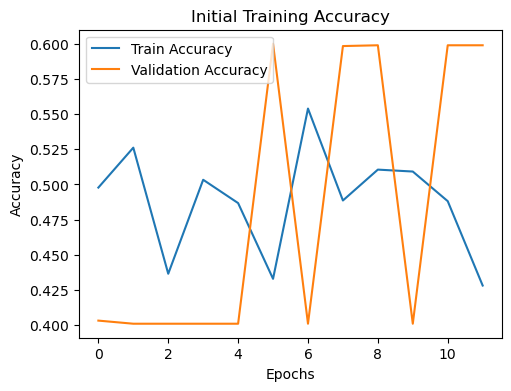

In [46]:
# Plotting the model accuracy 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

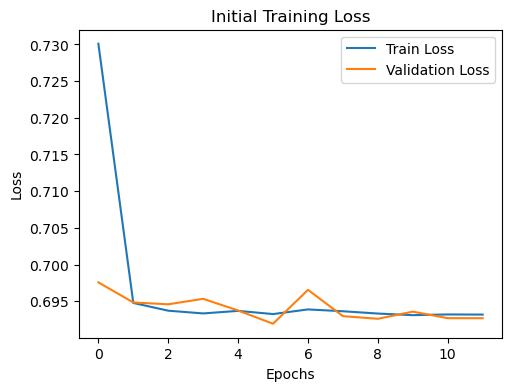

In [47]:
# Plotting the model loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**ResNet50 with ImageNet Weights**

Training Results:
- Accuracy: 0.7672
- Loss: 0.5224

Test Results:
- Accuracy: 0.6448
- Loss: 0.6279

**Question: Was this model successful?** No.

**Analysis**: 

The training accuracy (0.7672) is significantly higher than the test accuracy (0.6448), which suggests some degree of overfitting. The model performs well on the training data but struggles to generalize to unseen data. 

The loss values (training: 0.5224, test: 0.6279) also indicate a gap, further supporting the overfitting observation. Using only 2 images per class likely limits the model's ability to generalize effectively, as it doesn't have enough data to learn robust features.

## Model #4: ResNet50V2 

### Re-Define Data Generators 

In [48]:
# Re-define parameters 
img_size = (48, 48)
batch_size = 64
num_classes = 2

In [49]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  # Use 15% of training data for validation
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',  # ResNet50V2 expects 3-channel RGB images
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10239 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


### Load ResNet50V2 (Pretrained weights)

In [50]:
# Define the model architecture 
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # 2 emotion classes

model_4 = Model(inputs=base_model.input, outputs=output)

In [51]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False# Freeze the base model layers

# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 14, 14,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 12, 12,    │          0 │ conv2_block1_0_c

 Total params: 23,827,330 (90.89 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [52]:
# Callbacks for training
callbacks_training = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [53]:
# Train the model (custom head only)
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training
)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5573 - loss: 1.1817 - val_accuracy: 0.6786 - val_loss: 0.6416 - learning_rate: 1.0000e-04
Epoch 2/20
  1/159 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.6406 - loss: 0.7975

/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6406 - loss: 0.7975 - val_accuracy: 0.6540 - val_loss: 0.6655 - learning_rate: 1.0000e-04
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 952s 6s/step - accuracy: 0.6231 - loss: 0.7395 - val_accuracy: 0.6747 - val_loss: 0.6283 - learning_rate: 1.0000e-04
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6250 - loss: 0.6431 - val_accuracy: 0.6691 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.6610 - loss: 0.6432 - val_accuracy: 0.6981 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6719 - loss: 0.6633 - val_accuracy: 0.6691 - val_loss: 0.6092 - learning_rate: 1.0000e-04
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.6715 - loss: 0.6183 - val_accuracy: 0.6836 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.

In [54]:
# Unfreeze some layers for fine-tuning (in base model)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_4.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training,
)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.5884 - loss: 0.6984 - val_accuracy: 0.6613 - val_loss: 0.6217 - learning_rate: 1.0000e-05
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5625 - loss: 0.6660 - val_accuracy: 0.6652 - val_loss: 0.6304 - learning_rate: 1.0000e-05
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.6249 - loss: 0.6624 - val_accuracy: 0.6657 - val_loss: 0.6382 - learning_rate: 1.0000e-05
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6875 - loss: 0.5995 - val_accuracy: 0.6546 - val_loss: 0.6305 - learning_rate: 1.0000e-05
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.6461 - loss: 0.6416 - val_accuracy: 0.6529 - val_loss: 0.6373 - learning_rate: 5.0000e-06
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6562 - loss: 0.6108 - val_accuracy: 0.6607 - val_loss: 0.6341 - learning_rate: 5.0000e-06


### Evaluate 

In [55]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_4.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8186 - loss: 0.4552
Test Loss: 0.5868, Test Accuracy: 0.7005


In [ ]:
# Save the weights
model_4.save_weights('ResNet50V2_weights.weights.h5')

**ResNet50V2 with ImageNet Weights**

Training Results:
- Accuracy: 0.8186
- Loss: 0.4552

Test Results:
- Accuracy: 0.7005
- Loss: 0.5868

**Question: Was this model successful?** No.

**Analysis**: ResNet50V2 outperforms ResNet50 in both training and test accuracy, indicating that the architectural improvements in ResNet50V2 (e.g., better normalization and residual connections) help the model learn more effectively. The test accuracy for ResNet50V2 (0.7005) is higher than ResNet50's (0.6448), showing better generalization to unseen data. However, the dataset's limitations (small size, low resolution, and class imbalance) still hinder the model's ability to generalize effectively. Need to get it above 75%. 